In [1]:
import sys
sys.path.append("./")
import pandas as pd
import numpy as np
from settings import settings, paths
import os
import muffin
import scanpy as sc
adata = sc.read_10x_mtx(
    paths.scRNAseqGenes,  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

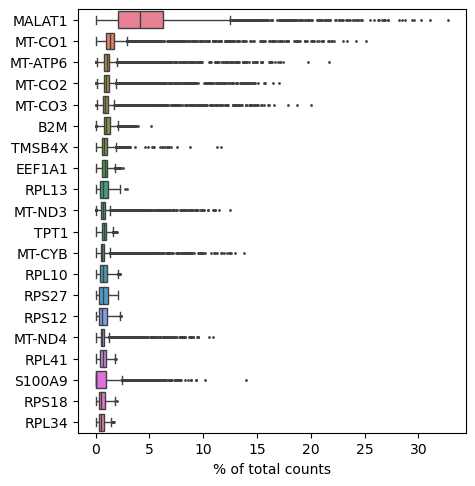

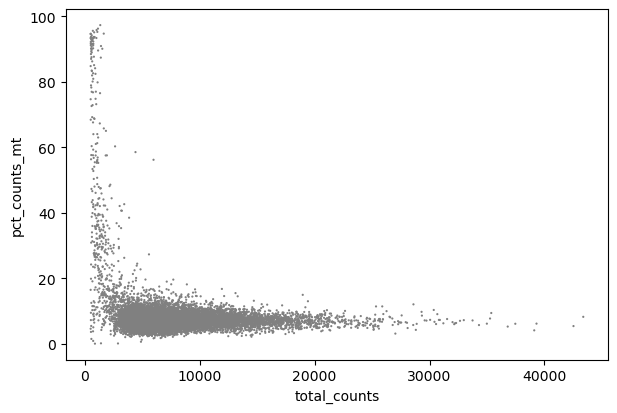

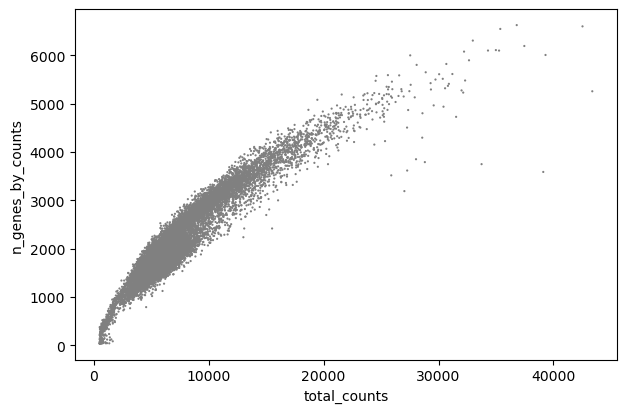

In [3]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
sc.pl.highest_expr_genes(adata, n_top=20, )
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
adata = adata[adata.obs.pct_counts_mt < 15, :]
adata = adata[adata.obs.n_genes_by_counts < 4000, :]
adata = adata[adata.obs.n_genes_by_counts > 1000, :]

In [4]:
sc.pp.normalize_total(adata, target_sum=1e4)

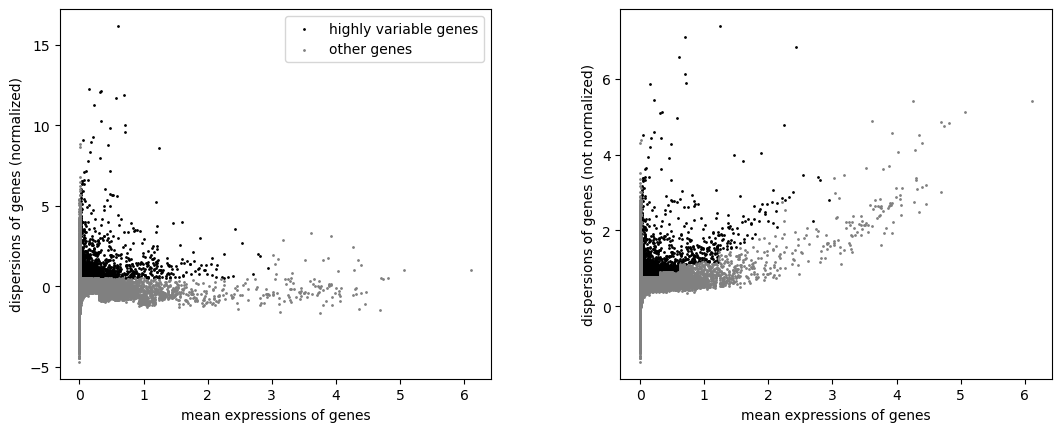

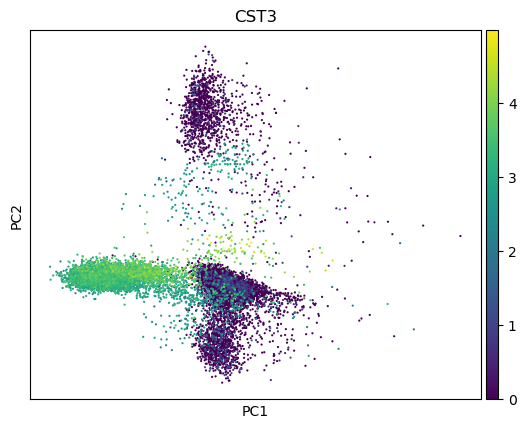

In [5]:
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')

In [8]:
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)

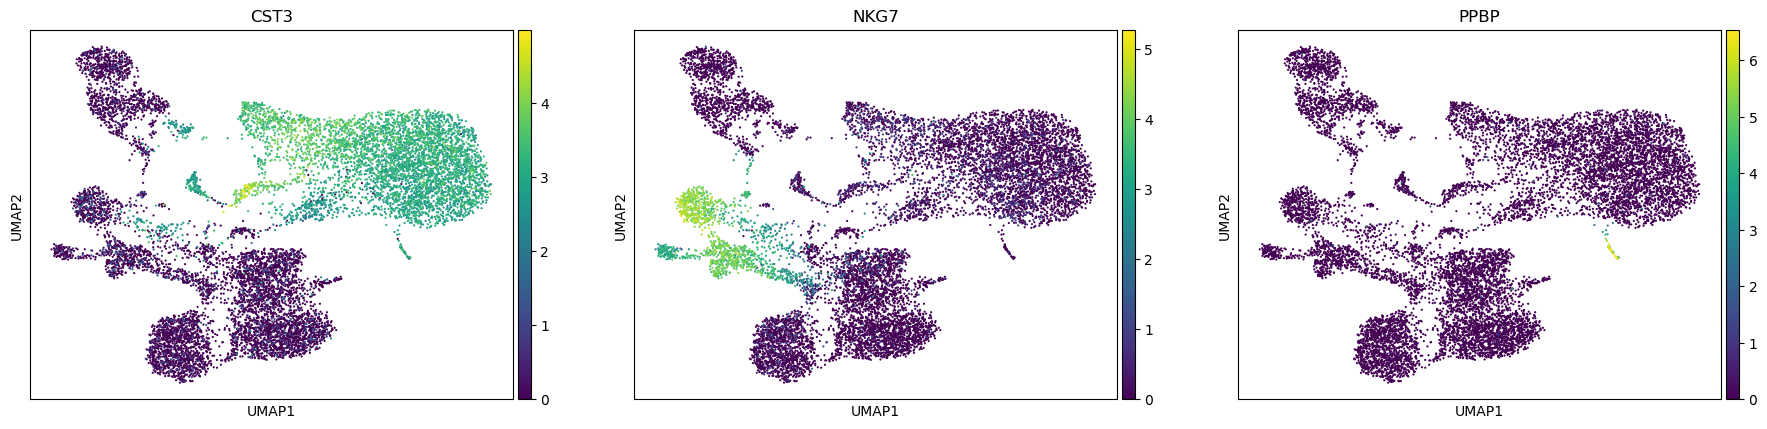

In [9]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

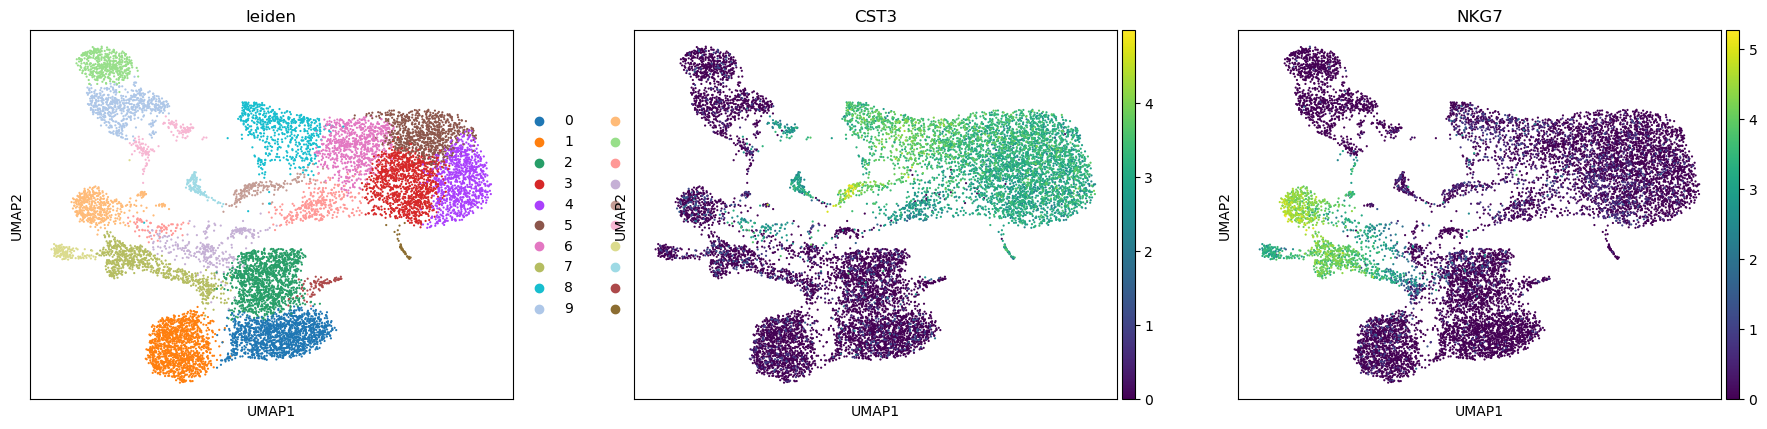

In [11]:
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])
adata.obs.to_csv("benchmarks/scrnaseq/10k_pbmc_scanpy_clusters.csv")